<a href="https://colab.research.google.com/github/rballachay/homework/blob/main/COMP579/COMP579_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP579 Assignment #2  
Riley Ballachay (261019324)    
Zhanwen Xin (261136034)  

The two authors contribute equally to the assignment

# Question 1 - SARSA 

## Step 1: Import environment + data

In [ ]:
import gym

## NOTE: we need to set the max episode steps. If we think about it, our discounted return will
## be at best 0.95**100 =~ 0.006 after 100 steps anyways, so this probably won't help. we were
# running into scenarios where the agent was milling around until ~1000 steps or more, essentially
# wasting time as the discounted reward is already effectively zero
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, max_episode_steps=100)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
import numpy as np
from numpy import random
from copy import copy

class Boltzmann:
    def __init__(self, T:int=1):
        self.T = T

    def __call__(self, Q, S, eval=False):
      """
      takes Q, the matrix of state-action 
      + the current state, returns the optimal
      action based on temperature
      """

      # if we are being greedy, dont need to calculate
      # probs, just use the values directly 
      if eval:
          act_probs = Q[S,:]
      else:
          act_probs = self.prob(Q, S)

      # using this instead of np.argmax, because it randomly
      # chooses if there is a tie in the best index, instead
      # of always choosing zero
      best_idxs = np.flatnonzero(act_probs == act_probs.max())
      return np.random.choice(best_idxs)

    def prob(self, Q, S):
        exps = np.exp(Q[S,:]/self.T)
        return exps/exps.sum()
 
class SARSA:
    def __init__(self, env, explorer, alpha, gamma):
        self.env = env

        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.explorer = explorer
        self.alpha = alpha
        self.gamma = gamma

        # attribute that says if the agent is lost
        # aka, we need to run start
        self.terminated = True

    def start(self):
        self.state = self.env.reset()
        # reset terminated
        self.terminated=False

        self.action = self.__get_act(self.Q, self.state)

    def act(self, eval=False):
        self.last_state = copy(self.state)
        self.last_action = copy(self.action)

        # get new action + state 
        self.state, self.reward, terminated = self.__move(self.last_action)
        self.action = self.__get_act(self.Q, self.state, eval)

        # update Q matrix
        if not eval:
            self.update()

        self.terminated = terminated
        return self.state, self.reward, self.terminated
    
    def __move(self, action):
        new_state, reward, terminated, info = self.env.step(action) 
        return new_state, reward, terminated


    def __get_act(self, Q, state, eval=False):
      if self.terminated:
          raise Exception('agent cannot act! reset state with SARSA.start')
      return self.explorer(Q, state, eval) 

    def update(self):
        target = self.gamma * self.Q[self.state, self.action]
        predict = self.Q[self.last_state, self.last_action]
        self.Q[self.last_state, self.last_action] = predict + self.alpha * (self.reward + target - predict)

class ExpectedSARSA(SARSA):
    def update(self):
        predict = self.Q[self.last_state, self.last_action]
        pi = self.explorer.prob(self.Q, self.state)
        target = self.gamma*(pi*self.Q[self.state]).sum()
        self.Q[self.last_state, self.last_action] = predict + self.alpha * (self.reward + target - predict)


In [ ]:
import itertools
from copy import copy
from multiprocessing import Pool, cpu_count
import time

#Defining the different parameters
SEGMENTS = 500
TEST_STEPS = 10
RUNS = 2
GAMMA = 0.95

class Experiment:
    def __init__(self, model, explorer, env, test_steps=TEST_STEPS, \
                 segments=SEGMENTS, runs=RUNS, gamma=GAMMA):

        self.model = model
        self.explorer = explorer
        self.env = env
        self.test_steps = test_steps
        self.segments = segments
        self.runs = runs
        self.gamma = gamma

        self.defaults = {
            'model':{'gamma':GAMMA},
            'explorer':{}
        }

        self.results = []

    def run(self, alphas:list, temps:list):
        perms = list(itertools.product(alphas, temps, range(self.runs)))

        start = time.time()
        self.results = list(map(self._pool_inner, perms))

        end = time.time()
        print(f'elapsed={end-start}')

    def _pool_inner(self, perm):
        a_i, t_i, i = perm
        env_i = copy(self.env)
        exp_i = copy(self.explorer(t_i))
        model_i = copy(self.model(env=env_i, alpha=a_i, explorer=exp_i, \
                                   **self.defaults['model']))
        
        # set random seeds
        np.random.seed(i)
        env_i.seed(i)

        # actually run model
        train_reward, test_reward = self.__run_model(model_i)

        # append to results
        results={'iteration':i+1, 'train_reward':train_reward, 'test_reward':test_reward, 'alpha':a_i, 'temp':t_i}
        return results

    def __run_model(self, model):
        # Starting the SARSA learning
        train_rewards = []
        test_rewards = []
        for episode in range(self.segments):
            # at every episode, train 10 times
            for _ in range(self.test_steps):
                train_reward = self.__go_terminal(model)
                train_rewards.append(train_reward)
            # at every episode, eval once
            test_reward = self.__go_terminal(model, eval=True)
            test_rewards.append(test_reward)

        return np.mean(train_rewards[-10:]), test_rewards[-1]

    def __go_terminal(self, model, eval=False):
        # place agent back at start
        model.start() 
        rewards = []

        # while agent is still on the lake,
        # and hasn't fallen off or won
        while not model.terminated:
            state, reward, _ = model.act(eval=eval)
            rewards.append(reward)
        #return rewards
        return self.__discount(rewards)

    def __discount(self, rewards):
        return rewards[-1] * self.gamma**len(rewards)

## SARSA Parameter Optimization

/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


elapsed=13635.107368946075


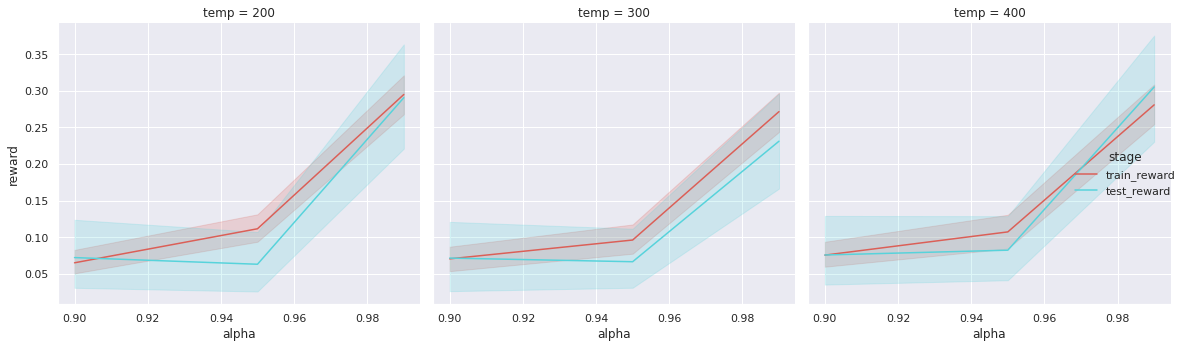

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd

exp = Experiment(SARSA, Boltzmann, env)

exp.run([0.9,0.95,0.99], [200,300,400] ) 

results = pd.DataFrame(exp.results)
results = pd.melt(results, id_vars=['temp','alpha','iteration'], value_vars=['train_reward','test_reward'],value_name='reward',var_name='stage')

sns.set_theme()
fg = sns.relplot(data=results, x='alpha',y='reward',hue='stage',col='temp',kind='line',palette='hls')
plt.tight_layout()

## Expected SARSA Parameter Optimization

/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


elapsed=8883.009940385818


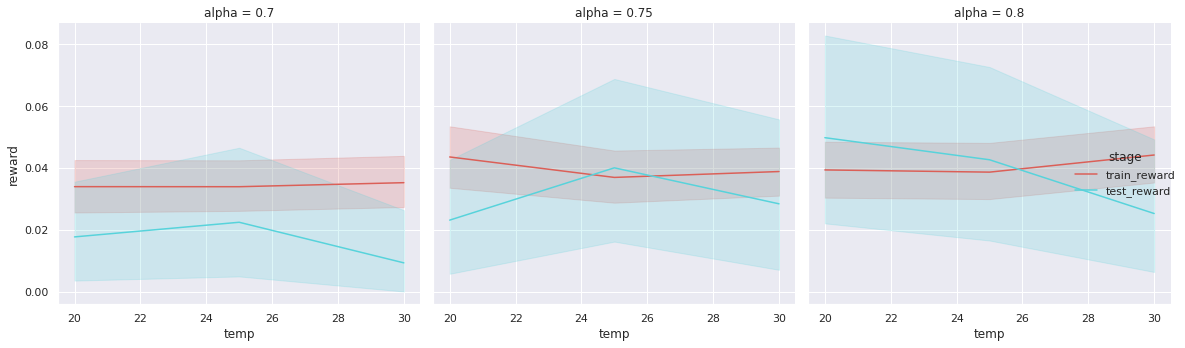

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd

exp = Experiment(ExpectedSARSA, Boltzmann, env)

# 9 x 500 x 10 x 10 = 450,000 loops
exp.run([0.7,0.75,0.8],[20,25,30]) 

results = pd.DataFrame(exp.results)
results = pd.melt(results, id_vars=['temp','alpha','iteration'], value_vars=['train_reward','test_reward'],value_name='reward',var_name='stage')

sns.set_theme()
fg = sns.relplot(data=results, x='temp',y='reward',hue='stage',col='alpha',kind='line',palette='hls')
plt.tight_layout()

# Question 2 - Q-Learning Function Approximation

In [ ]:
import gym
env = gym.make('CartPole-v1')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
import gym
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer 
from copy import copy, deepcopy
import itertools
import pandas as pd

class Discretizer:
    def __init__(self):
        self.n_bins = 10

    def __call__(self, x):
        return self.discretize_state(x)

    def discretize_state(self, state):
        """
        Input: state (list): state from gym environment, (4, )
        output: discrete_state (list): one-hot encoded state, (40, )
        """
        discretize_mesh = np.zeros((40, ), dtype=int)

        position_idx = self.map_bin(state[0], np.linspace(-4.8, 4.8, num = 11)[1:-1])
        velocity_idx = self.map_bin(state[1], [-0.58, -0.36, -0.2, -0.13, 0, 0.13, 0.2, 0.36, 0.58])
        angle_idx = self.map_bin(state[2], np.linspace(-0.418, 0.418, num = 11)[1:-1])
        angular_velocity_idx = self.map_bin(state[3], [-0.3, -0.2, -0.12, -0.05, 0.01, 0.07, 0.14, 0.22, 0.32])

        # discretize_mesh[position_idx, velocity_idx, angle_idx, angular_velocity_idx] = 1
        discretize_mesh[position_idx] = 1
        discretize_mesh[velocity_idx + 10] = 1
        discretize_mesh[angle_idx + 20] = 1
        discretize_mesh[angular_velocity_idx + 30] = 1

        discretize_state = discretize_mesh
        return discretize_state


    def map_bin(self, state, bin_division):
        """
        Input: 
          state (float): state to map, (1,)
          bin_division (list): (9, )
        output: map_index, (1, )
        """
        for i, max_val in enumerate(bin_division):
          if state < max_val:
            map_idx = i
            break
          map_idx = 9
        return map_idx

class Estimator:
    def __init__(self, env, discretizer, alpha, seed=0):
        np.random.seed(seed)
        self.weights = np.random.uniform(-0.001,0.001,(env.action_space.n, env.observation_space.shape[0]*discretizer.n_bins))
        self.nA = env.action_space.n 
        self.discretizer = discretizer
        self.alpha=alpha

    def predict(self, s, a=None):
        predictions = self.discretizer(s) @ self.weights.T
        if a is not None:
            predictions=predictions[a]
        return predictions
            
    def update(self, s, a, target):
        self.weights[a,:] += self.alpha*target*self.discretizer(s)


class EpsilonGreedy:
    def __init__(self, estimator, epsilon:int=1):
        self.estimator = estimator
        self.epsilon = epsilon

    def __call__(self, Q):
        best_idxs = np.argmax(Q)
        A  = np.ones(self.estimator.nA, dtype=float) * self.epsilon / self.estimator.nA
        A[best_idxs] += (1.0 - self.epsilon)
        return np.random.choice(np.arange(self.estimator.nA), p=A)

class QLearning:
    def __init__(self, env, estimator, num_episodes, epsilon, decay_rate):
        self.env = deepcopy(env)
        self.estimator = deepcopy(estimator)
        self.num_episodes = num_episodes
        self.policy=EpsilonGreedy(estimator, epsilon)
        self.n_actions = self.env.action_space.n
        self.decay_rate = decay_rate

        self.stats = {
          'episode_rewards':np.zeros(num_episodes),
          'episode_lengths':np.zeros(num_episodes)
        } 
        self.coefs=[]


    def run(self):
        for i_episode in range(self.num_episodes):        
            state = self.env.reset()
            for t in itertools.count():
                # start with new state each episode

                # choose an action from this state based on policy
                q_values_old_state = self.estimator.predict(state)
                action=self.policy(q_values_old_state)
                
                # Perform the action -> Get the reward and observe the next state
                new_state, reward, terminated, _ = self.env.step(action)
        
                self.stats['episode_rewards'][i_episode] += reward
                self.stats['episode_lengths'][i_episode] = t
                
                # get the based q values at the new state
                td_target = reward + self.decay_rate * np.max(self.estimator.predict(new_state)) - q_values_old_state[action]
                self.estimator.update(state, action, td_target)            
                
                if t%10==0:
                    self.coefs.append(copy(self.estimator.weights))
                state = new_state
                
                if terminated:
                    break
    
        return self.stats, self.coefs


class Critic:
    def __init__(self, env, discretizer, alpha, seed=0):
        np.random.seed(seed)
        self.weights = np.random.uniform(-0.001,0.001,(1, env.observation_space.shape[0]*discretizer.n_bins))
        self.nA = env.action_space.n 
        self.discretizer = discretizer
        self.alpha=alpha

    def predict(self, s):
        predictions = self.discretizer(s) @ self.weights.T
        return predictions
            
    def update(self, s, target):
        self.weights += self.alpha*target*self.discretizer(s)


class Actor:
    def __init__(self, env, discretizer, alpha, seed=0):
        np.random.seed(seed)
        self.weights = np.random.uniform(-0.001,0.001,(env.action_space.n, env.observation_space.shape[0]*discretizer.n_bins))
        self.nA = env.action_space.n 
        self.discretizer = discretizer
        self.alpha=alpha

    def predict(self, s, a=None):
        predictions = self.discretizer(s) @ self.weights.T
        if a is not None:
            predictions=predictions[a]
        return predictions
            
    def update(self, s, a, target, log_pi):
        self.weights[a,:] += self.alpha*target*log_pi*self.discretizer(s)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class ActorCritic:
    def __init__(self, env, estimator, actor, num_episodes, decay_rate):
        self.env = deepcopy(env)
        self.critic = deepcopy(estimator)
        self.num_episodes = num_episodes
        self.actor = deepcopy(actor)
        self.n_actions = self.env.action_space.n
        self.decay_rate = decay_rate

        self.stats = {
          'episode_rewards':np.zeros(num_episodes),
          'episode_lengths':np.zeros(num_episodes)
        } 
        self.coefs=[]


    def run(self):
        for i_episode in range(self.num_episodes):        
            state = self.env.reset()
            for t in itertools.count():
                # start with new state each episode

                # choose an action from this state based on policy
                probs = sigmoid(self.actor.predict(state))

                # get q values from critic
                state_value_old = self.critic.predict(state)

                action=np.random.choice(len(probs), p=probs/probs.sum())
                
                # Perform the action -> Get the reward and observe the next state
                new_state, reward, terminated, _ = self.env.step(action)

                #log_prob = np.log(probs)[action]
                log_pi_gradient = 1/probs[action] * probs[action] * (1-probs[action]) 
        
                self.stats['episode_rewards'][i_episode] += reward
                self.stats['episode_lengths'][i_episode] = t
                
                # get the based q values at the new state
                td_target = reward + self.decay_rate * np.max(self.critic.predict(new_state)) - state_value_old
                self.critic.update(state, td_target)   
                self.actor.update(state, action, td_target, log_pi_gradient)         
                
                if t%10==0:
                    self.coefs.append(copy(self.critic.weights))

                state = new_state
                
                if terminated:
                    break
    
        return self.stats, self.coefs

class Experiment:
    def __init__(self, alphas, epsilons, num_reps, num_episodes, decay_rate):
        self.alphas = alphas 
        self.epsilons = epsilons
        self.num_reps = num_reps
        self.num_episodes = num_episodes
        self.decay_rate = decay_rate

        # only going to create one discretizer
        self.discretizer = Discretizer()

        self.results = []

    def run(self, env):
        for i in range(self.num_reps):
          for alpha, epsilon in itertools.product(self.alphas, self.epsilons):
              estimator = Estimator(env, discretizer=self.discretizer, alpha=alpha, seed=i)
              learner = QLearning(env, estimator, num_episodes=self.num_episodes, epsilon=epsilon, decay_rate=self.decay_rate)
              stats, _ = learner.run()

              self.results.append(
                  {
                      'alpha':alpha,
                      'epsilon':epsilon,
                      'replicate':i+1,
                      'episode':np.arange(self.num_episodes)+1,
                      'rewards':stats['episode_rewards']
                  }
              )

    @property
    def df(self):
        return pd.concat(list(map(pd.DataFrame, self.results))).reset_index(drop=True)


class ExperimentActorCritic:
    def __init__(self, alphas, num_reps, num_episodes, decay_rate):
        self.alphas = alphas 
        self.num_reps = num_reps
        self.num_episodes = num_episodes
        self.decay_rate = decay_rate

        # only going to create one discretizer
        self.discretizer = Discretizer()

        self.results = []

    def run(self, env):
        for i in range(self.num_reps):
          for alpha in self.alphas:
              estimator = Critic(env, discretizer=self.discretizer, alpha=alpha)
              actor = Actor(env, discretizer=self.discretizer, alpha=alpha)
              learner = ActorCritic(env, estimator, actor, num_episodes=self.num_episodes, decay_rate=self.decay_rate)
              stats, _ = learner.run()

              self.results.append(
                  {
                      'alpha':alpha,
                      'replicate':i+1,
                      'episode':np.arange(self.num_episodes)+1,
                      'rewards':stats['episode_rewards']
                  }
              )

    @property
    def df(self):
        return pd.concat(list(map(pd.DataFrame, self.results))).reset_index(drop=True)     

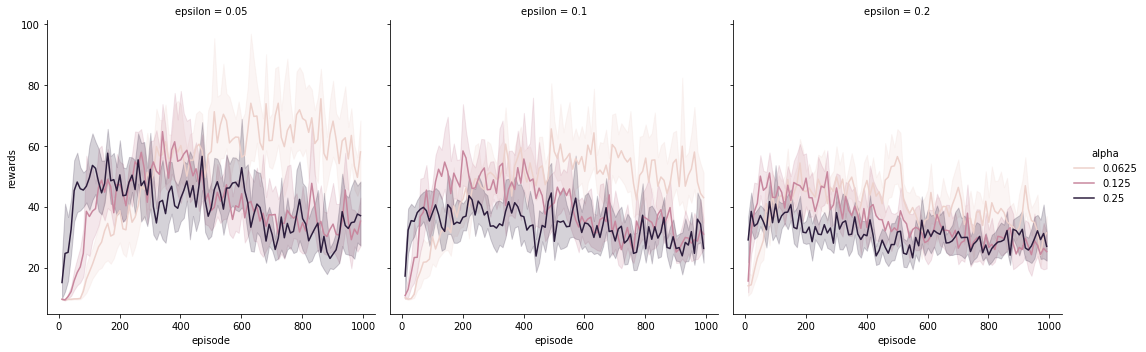

In [ ]:
import seaborn as sns

ALPHAS = [1/16, 1/8, 1/4]
EPSILONS = [0.05, 0.1, 0.2]
DECAY_RATE = 0.95
NUM_EPISODES = 1000
NUM_REPLICATES = 10

#exp = Experiment(ALPHAS, EPSILONS, NUM_REPLICATES, NUM_EPISODES, DECAY_RATE)
#exp.run(env)

df = exp.df
df['rewards'] = df.groupby(['epsilon','alpha','replicate'])['rewards'].transform(lambda x: x.rolling(10).mean())
df = df.iloc[::10]

sns.relplot(data=df, x='episode', y='rewards', hue='alpha',kind='line',col='epsilon')

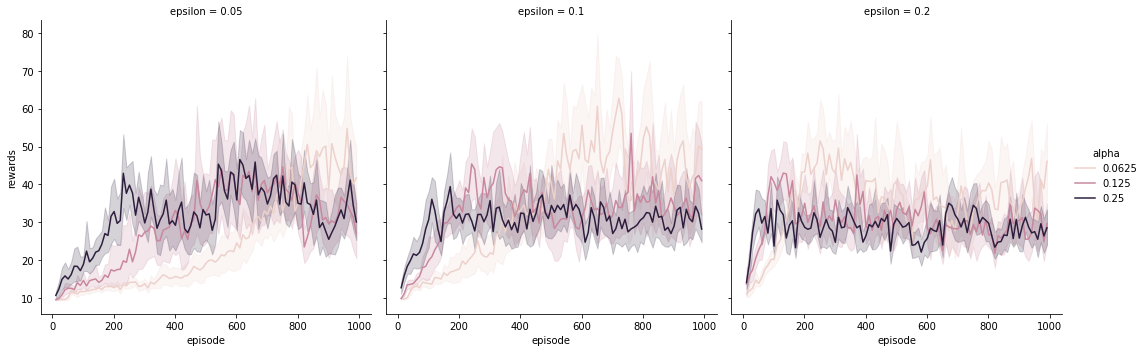

In [ ]:
import seaborn as sns

ALPHAS = [1/16, 1/8, 1/4]
EPSILONS = [0.05, 0.1, 0.2]
DECAY_RATE = 0.95
NUM_EPISODES = 1000
NUM_REPLICATES = 10

exp = Experiment(ALPHAS, EPSILONS, NUM_REPLICATES, NUM_EPISODES, DECAY_RATE)
exp.run(env)

df = exp.df
df['rewards'] = df.groupby(['epsilon','alpha','replicate'])['rewards'].transform(lambda x: x.rolling(10).mean())
df = df.iloc[::10]

sns.relplot(data=df, x='episode', y='rewards', hue='alpha',kind='line',col='epsilon')

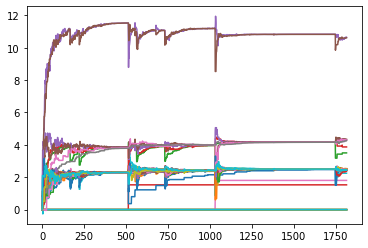

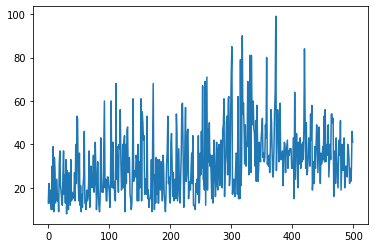

In [ ]:
import matplotlib.pyplot as plt

ALPHA=1/4
NUM_EPISODES = 500
DECAY_RATE = 0.95

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

discretizer = Discretizer()
estimator = Critic(env, discretizer=discretizer, alpha=ALPHA)
actor = Actor(env, discretizer=discretizer, alpha=ALPHA)

stats, coefs = ActorCritic(env, estimator, actor, num_episodes=NUM_EPISODES, decay_rate=DECAY_RATE).run()
coefs_np = np.array(coefs)[:,0,:]
plt.plot(np.linspace(0,coefs_np.shape[0], coefs_np.shape[0]),coefs_np)
plt.show()


plt.plot(stats['episode_rewards'])
plt.show()

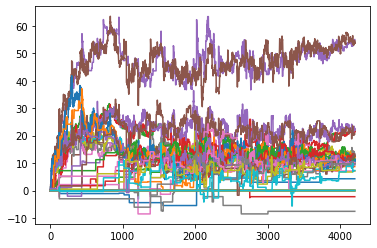

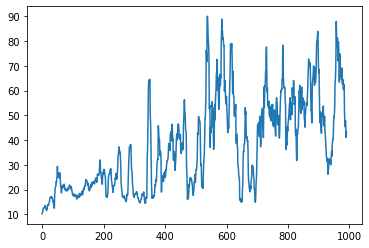

In [ ]:
import matplotlib.pyplot as plt

ALPHA=1/4
NUM_EPISODES = 1000
DECAY_RATE = 0.99
EPSILON = 0.05

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

discretizer = Discretizer()
estimator = Estimator(env, discretizer=discretizer, alpha=ALPHA)

stats, coefs = QLearning(env, estimator, num_episodes=NUM_EPISODES, decay_rate=DECAY_RATE, epsilon=EPSILON).run()
coefs_np = np.array(coefs)[:,0,:]
plt.plot(np.linspace(0,coefs_np.shape[0], coefs_np.shape[0]),coefs_np)
plt.show()


plt.plot(moving_average(stats['episode_rewards'],10))
plt.show()

<Figure size 720x360 with 0 Axes>

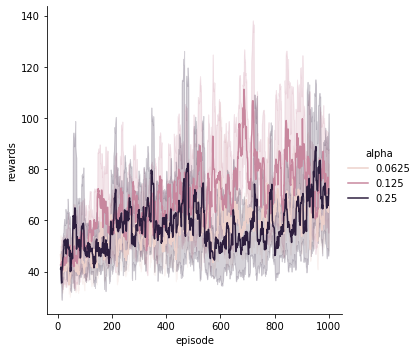

In [ ]:
import seaborn as sns

ALPHAS = [1/16, 1/8, 1/4]
DECAY_RATE = 0.95
NUM_EPISODES = 1000
NUM_REPLICATES = 10

#exp = ExperimentActorCritic(ALPHAS, NUM_REPLICATES, NUM_EPISODES, DECAY_RATE)
#exp.run(env)

df = exp.df
df['rewards'] = df.groupby(['alpha','replicate'])['rewards'].transform(lambda x: x.rolling(10).max())
#df = df.iloc[::10]

plt.figure(figsize=(10,5))
sns.relplot(data=df, x='episode', y='rewards', hue='alpha',kind='line')